In [44]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [37]:
from google.colab import userdata
api_key = userdata.get('cos_api_key')

## [3.5] 902Y014 외환보유액

  - 한국 KR
  - 미국 US
  - 중국 CN (불안정)

  미국과 한국 위주로 EDA 및 시각화

In [38]:
import requests
import pandas as pd

start_m = "200001"
end_m = "202412"
start_q = "2000Q1"
end_q = "2024Q4"

In [10]:
# 월간 데이터 호출 함수
def get_ecos_monthly(stat_code, item_code, col_name):
    url = f"https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/{stat_code}/M/{start_m}/{end_m}/{item_code}/?/?/?"
    res = requests.get(url).json()

    if "StatisticSearch" in res and "row" in res["StatisticSearch"]:
        df = pd.DataFrame(res["StatisticSearch"]["row"])
        if 'ITEM_NAME2' in df.columns and '평균자료' in df['ITEM_NAME2'].values:
            df = df[df['ITEM_NAME2'] == '평균자료']
        df = df[['TIME', 'DATA_VALUE']]
        df.columns = ['날짜', col_name]
        df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m').dt.to_period("M")
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
        return df.set_index("날짜")
    else:
        print(f"⚠️ {col_name} (월간) 데이터 없음 또는 오류")
        return pd.DataFrame()

# 분기 데이터 호출 함수
def get_ecos_quarterly(stat_code, item_code, col_name):
    url = f"https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/{stat_code}/Q/{start_q}/{end_q}/{item_code}/?/?/?"
    res = requests.get(url).json()

    if "StatisticSearch" in res and "row" in res["StatisticSearch"]:
        df = pd.DataFrame(res["StatisticSearch"]["row"])
        if 'ITEM_NAME2' in df.columns and '평균자료' in df['ITEM_NAME2'].values:
            df = df[df['ITEM_NAME2'] == '평균자료']
        df = df[['TIME', 'DATA_VALUE']]
        df.columns = ['날짜', col_name]
        df['날짜'] = df['날짜'].str.replace("/", "")  # 2021/Q4 → 2021Q4
        df['날짜'] = pd.PeriodIndex(df['날짜'], freq='Q')
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
        return df.set_index("날짜")
    else:
        print(f"⚠️ {col_name} (분기) 데이터 없음 또는 오류")
        return pd.DataFrame()

In [11]:
# 병합용 빈 프레임
df_monthly = pd.DataFrame()
df_quarterly = pd.DataFrame()

# 월간 데이터 목록
monthly_items = [
    ("731Y006", "0000003", "원/달러 평균환율"),
    ("902Y014", "KR", "한국 외환보유액"),
    ("902Y014", "US", "미국 외환보유액"),
    ("902Y006", "KR", "한국 기준금리"),
    ("902Y006", "US", "미국 기준금리"),
    ("513Y001", "E1000", "경제심리지수"),
    ("511Y004", "FME", "소비자동향지수"),
    ("521Y001", "A001", "뉴스심리지수"),
]

# 분기 데이터 목록
quarterly_items = [
    ("902Y009", "KR", "한국 경상수지"),
    ("902Y009", "US", "미국 경상수지"),
    ("902Y010", "KR", "한국 무역수지"),
    ("902Y010", "US", "미국 무역수지"),
    ("901Y061", "FF2B", "외국인 투자금액"),
    ("902Y015", "KOR", "한국 경제성장률"),
    ("902Y015", "USA", "미국 경제성장률"),
]

# 1️⃣ 월간 데이터 병합
for stat_code, item_code, col_name in monthly_items:
    print(f"📥 월간 {col_name} 불러오는 중...")
    df = get_ecos_monthly(stat_code, item_code, col_name)
    if df.empty:
        continue
    df_monthly = df if df_monthly.empty else df_monthly.join(df, how="outer")

# 2️⃣ 분기 데이터 병합
for stat_code, item_code, col_name in quarterly_items:
    print(f"📥 분기 {col_name} 불러오는 중...")
    df = get_ecos_quarterly(stat_code, item_code, col_name)
    if df.empty:
        continue
    df_quarterly = df if df_quarterly.empty else df_quarterly.join(df, how="outer")

# 결과 출력
print("\n✅ 병합 완료!")
print("월간 데이터 shape:", df_monthly.shape)
print("분기 데이터 shape:", df_quarterly.shape)

# 원한다면 저장도 가능
# df_monthly.to_csv("월간_데이터.csv")
# df_quarterly.to_csv("분기_데이터.csv")


📥 월간 원/달러 평균환율 불러오는 중...
📥 월간 한국 외환보유액 불러오는 중...
📥 월간 미국 외환보유액 불러오는 중...
📥 월간 한국 기준금리 불러오는 중...
📥 월간 미국 기준금리 불러오는 중...
📥 월간 경제심리지수 불러오는 중...
📥 월간 소비자동향지수 불러오는 중...
📥 월간 뉴스심리지수 불러오는 중...
📥 분기 한국 경상수지 불러오는 중...
📥 분기 미국 경상수지 불러오는 중...
📥 분기 한국 무역수지 불러오는 중...
📥 분기 미국 무역수지 불러오는 중...
📥 분기 외국인 투자금액 불러오는 중...
📥 분기 한국 경제성장률 불러오는 중...
📥 분기 미국 경제성장률 불러오는 중...

✅ 병합 완료!
월간 데이터 shape: (1215, 8)
분기 데이터 shape: (100, 7)


### 월간 및 분기별 병합

In [12]:
# df_monthly: 월간 데이터 (index: Period[M])
# df_quarterly: 분기 데이터 (index: Period[Q])

# 1. 분기 데이터를 월간으로 확장
# 예: 2023Q1 → 2023-01, 2023-02, 2023-03
df_quarterly_expanded = df_quarterly.copy()

# 월별 인덱스 확장용 딕셔너리
expanded_rows = []

for idx, row in df_quarterly_expanded.iterrows():
    months = [idx.start_time + pd.DateOffset(months=i) for i in range(3)]
    for m in months:
        expanded_rows.append((m.to_period("M"), row.values))

# DataFrame 재구성
df_expanded = pd.DataFrame(
    [val for _, val in expanded_rows],
    index=[idx for idx, _ in expanded_rows],
    columns=df_quarterly.columns
)

# 2. df_monthly 기준으로 병합
df_final = df_monthly.join(df_expanded, how="left")

# 결과 확인
print("병합된 데이터프레임 shape:", df_final.shape)
df_final.head()

병합된 데이터프레임 shape: (1215, 15)


,원/달러 평균환율,한국 외환보유액,미국 외환보유액,한국 기준금리,미국 기준금리,경제심리지수,소비자동향지수,뉴스심리지수,한국 경상수지,미국 경상수지,한국 무역수지,미국 무역수지,외국인 투자금액,한국 경제성장률,미국 경제성장률
2000-01,1130.32,NaN,NaN,4.75,5.50,NaN,NaN,NaN,-266.9,-84585.0,948.7,-98066.0,2267485.0,1.995,0.363
2000-02,1129.29,NaN,NaN,5.00,5.75,NaN,NaN,NaN,-266.9,-84585.0,948.7,-98066.0,2267485.0,1.995,0.363
2000-03,1115.75,NaN,NaN,5.00,6.00,NaN,NaN,NaN,-266.9,-84585.0,948.7,-98066.0,2267485.0,1.995,0.363
2000-04,1110.01,NaN,NaN,5.00,6.00,NaN,NaN,NaN,2653.9,-96104.0,4835.0,-106480.0,2999615.0,1.541,1.821
2000-05,1121.37,NaN,NaN,5.00,6.50,NaN,NaN,NaN,2653.9,-96104.0,4835.0,-106480.0,2999615.0,1.541,1.821


In [13]:
df_final.isnull().sum()

,0
원/달러 평균환율,0
한국 외환보유액,60
미국 외환보유액,20
한국 기준금리,0
미국 기준금리,0
경제심리지수,36
소비자동향지수,215
뉴스심리지수,60
한국 경상수지,0
미국 경상수지,3


### 최종병합파일

In [3]:
import pandas as pd

exchange = pd.read_csv('/content/exchange_2000_2024.csv')

In [5]:
exchange.head()

,TIME,원/달러환율,한국 장기 시장 금리,미국 장기 시장 금리,중국 장기 시장 금리,한국 단기 시장 금리,미국 단기 시장 금리,중국 단기 시장 금리,전체 수출 총액,미국 수출 총액,...,중국 상품수지,한국 경제성장률,미국 경제성장률,중국 경제성장률,한국 GDP,미국 GDP,중국 GDP,한국 GDP 디플레이터,한국 중앙정부 부채 비율,미국 중앙정부 부채 비율
0,2000-01,1130.32,NaN,6.66,NaN,7.28,5.95,2.72,12162425,2609788,...,NaN,1.995,0.363,NaN,597801.700000,1.025095e+07,1.223755e+06,67.68900,NaN,33.267642
1,2000-02,1129.29,NaN,6.52,NaN,7.13,6.01,2.73,12676042,2554310,...,NaN,1.844,0.849,NaN,595289.458333,1.027853e+07,1.234695e+06,67.88875,NaN,34.865592
2,2000-03,1115.75,NaN,6.26,NaN,7.00,6.14,2.64,14429703,2946821,...,NaN,1.692,1.335,NaN,592777.216667,1.030611e+07,1.245635e+06,68.08850,NaN,36.463543
3,2000-04,1110.01,NaN,5.99,NaN,7.06,6.28,2.64,13522040,2698030,...,NaN,1.541,1.821,NaN,590264.975000,1.033370e+07,1.256575e+06,68.28825,NaN,38.061493
4,2000-05,1121.37,NaN,6.44,NaN,7.14,6.71,2.57,14636755,3167181,...,NaN,1.943,1.248,NaN,587752.733333,1.036128e+07,1.267515e+06,68.48800,NaN,39.659444


In [6]:
exchange.isnull().sum()

,0
TIME,0
원/달러환율,0
한국 장기 시장 금리,9
미국 장기 시장 금리,0
중국 장기 시장 금리,168
...,...
미국 GDP,11
중국 GDP,11
한국 GDP 디플레이터,11
한국 중앙정부 부채 비율,167


In [18]:
exchange.columns

Index(['TIME', '원/달러환율', '한국 장기 시장 금리', '미국 장기 시장 금리', '중국 장기 시장 금리',
       '한국 단기 시장 금리', '미국 단기 시장 금리', '중국 단기 시장 금리', '전체 수출 총액', '미국 수출 총액',
       '중국 수출 총액', '전체 수입 총액', '미국 수입 총액', '중국 수입 총액', '소득 교역 조건 지수',
       '해외 직접 투자 금액', '경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '중국 기준 금리',
       '한국 소비자 물가지수', '미국 소비자 물가지수', '중국 소비자 물가지수', '한국 외환 보유액', '미국 외환 보유액',
       '중국 외환 보유액', '한국 산업 생산 지수', '미국 산업 생산 지수', '한국 실업률', '미국 실업률',
       '한국 주가지수', '미국 주가지수', '중국 주가지수', 'WTI 유가', '두바이 유가', 'Brent 유가',
       '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격', '알루미늄 가격', '니켈 가격', '아연 가격',
       '금 가격', '대두 가격', '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격', '외국인 투자 금액',
       '한국 경상수지', '미국 경상수지', '중국 경상수지', '한국 상품수지', '미국 상품수지', '중국 상품수지',
       '한국 경제성장률', '미국 경제성장률', '중국 경제성장률', '한국 GDP', '미국 GDP', '중국 GDP',
       '한국 GDP 디플레이터', '한국 중앙정부 부채 비율', '미국 중앙정부 부채 비율'],
      dtype='object')

### 담당 변수 및 관련 변수 추출

In [4]:
# 필요한 변수 컬럼명 리스트
selected_columns = [
    "TIME",
    "원/달러환율",
    "한국 외환 보유액", "미국 외환 보유액",
    "한국 기준 금리", "미국 기준 금리",
    "전체 수출 총액", "미국 수출 총액", "중국 수출 총액",
    "전체 수입 총액", "미국 수입 총액", "중국 수입 총액",
    "소득 교역 조건 지수", "외국인 투자 금액",
    "한국 경상수지", "미국 경상수지",
    "한국 상품수지", "미국 상품수지",
    "한국 경제성장률", "미국 경제성장률",
    "경제 심리 지수"
]
df_exchange = exchange[selected_columns].copy()

In [5]:
df_exchange.columns

Index(['TIME', '원/달러환율', '한국 외환 보유액', '미국 외환 보유액', '한국 기준 금리', '미국 기준 금리',
       '전체 수출 총액', '미국 수출 총액', '중국 수출 총액', '전체 수입 총액', '미국 수입 총액', '중국 수입 총액',
       '소득 교역 조건 지수', '외국인 투자 금액', '한국 경상수지', '미국 경상수지', '한국 상품수지', '미국 상품수지',
       '한국 경제성장률', '미국 경제성장률', '경제 심리 지수'],
      dtype='object')

### 추가 분석 데이터 호출

In [6]:
import pandas as pd
import requests

start = "200001"
end = "202412"
period = "M"

# API 호출 함수 (월간)
def get_ecos_data(stat_code, item_code, col_name):
    url = f"https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/{stat_code}/{period}/{start}/{end}/{item_code}/?/?/?"
    res = requests.get(url).json()

    if 'StatisticSearch' in res and 'row' in res['StatisticSearch']:
        df = pd.DataFrame(res['StatisticSearch']['row'])
        df = df[["TIME", "DATA_VALUE"]]
        df.columns = ["날짜", col_name]
        df["날짜"] = pd.to_datetime(df["날짜"], format="%Y%m")
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
        return df.set_index("날짜")
    else:
        print(f"⚠️ {col_name} 데이터 없음 또는 오류")
        return pd.DataFrame()

# 1. 소비자동향지수
df_consumer_sentiment = get_ecos_data("511Y004", "FME", "소비자동향지수")

# 2. 뉴스심리지수
df_news_sentiment = get_ecos_data("521Y001", "A001", "뉴스심리지수")

# 3. 기존 df_exchange에 병합
df_exchange = df_exchange.join(df_consumer_sentiment, how="left")
df_exchange = df_exchange.join(df_news_sentiment, how="left")

# 확인
df_exchange.columns


Index(['TIME', '원/달러환율', '한국 외환 보유액', '미국 외환 보유액', '한국 기준 금리', '미국 기준 금리',
       '전체 수출 총액', '미국 수출 총액', '중국 수출 총액', '전체 수입 총액', '미국 수입 총액', '중국 수입 총액',
       '소득 교역 조건 지수', '외국인 투자 금액', '한국 경상수지', '미국 경상수지', '한국 상품수지', '미국 상품수지',
       '한국 경제성장률', '미국 경제성장률', '경제 심리 지수', '소비자동향지수', '뉴스심리지수'],
      dtype='object')

In [7]:
df_exchange.head()

,TIME,원/달러환율,한국 외환 보유액,미국 외환 보유액,한국 기준 금리,미국 기준 금리,전체 수출 총액,미국 수출 총액,중국 수출 총액,전체 수입 총액,...,외국인 투자 금액,한국 경상수지,미국 경상수지,한국 상품수지,미국 상품수지,한국 경제성장률,미국 경제성장률,경제 심리 지수,소비자동향지수,뉴스심리지수
0,2000-01,1130.32,NaN,NaN,4.75,5.50,12162425,2609788,1235215,12594623,...,2267485.0,-266.900,-84585.000,948.700,-98066.000,1.995,0.363,NaN,NaN,NaN
1,2000-02,1129.29,NaN,NaN,5.00,5.75,12676042,2554310,1273117,12023652,...,2511528.0,706.700,-88424.667,2244.133,-100870.667,1.844,0.849,NaN,NaN,NaN
2,2000-03,1115.75,NaN,NaN,5.00,6.00,14429703,2946821,1437377,14212011,...,2755572.0,1680.300,-92264.333,3539.567,-103675.333,1.692,1.335,NaN,NaN,NaN
3,2000-04,1110.01,NaN,NaN,5.00,6.00,13522040,2698030,1366877,13344532,...,2999615.0,2653.900,-96104.000,4835.000,-106480.000,1.541,1.821,NaN,NaN,NaN
4,2000-05,1121.37,NaN,NaN,5.00,6.50,14636755,3167181,1663241,13283356,...,3574766.0,3060.533,-102391.000,4983.367,-111980.000,1.943,1.248,NaN,NaN,NaN


#### 기대인플레이션 가져오기

- 200202부터 존재

In [8]:
# 기대 인플레이션율 API 호출 코드 예시
def get_expectation_inflation(api_key):
    url = f"https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/511Y003/M/200202/202503/FMB"
    res = requests.get(url).json()

    if "StatisticSearch" in res and "row" in res["StatisticSearch"]:
        df = pd.DataFrame(res["StatisticSearch"]["row"])
        df = df[["TIME", "DATA_VALUE"]].rename(columns={"TIME": "날짜", "DATA_VALUE": "기대인플레이션율"})
        df["날짜"] = pd.to_datetime(df["날짜"], format="%Y%m")
        df["기대인플레이션율"] = pd.to_numeric(df["기대인플레이션율"], errors="coerce")
        return df.set_index("날짜")
    else:
        print("❌ 기대 인플레이션 데이터 없음")
        return pd.DataFrame()

In [9]:
df_inflation = get_expectation_inflation(api_key)

# 🔗 병합 (보간 없이 해당 월에만 값 존재)
df_merged = df_exchange.join(df_inflation, how="left")

df_merged.head()

,TIME,원/달러환율,한국 외환 보유액,미국 외환 보유액,한국 기준 금리,미국 기준 금리,전체 수출 총액,미국 수출 총액,중국 수출 총액,전체 수입 총액,...,한국 경상수지,미국 경상수지,한국 상품수지,미국 상품수지,한국 경제성장률,미국 경제성장률,경제 심리 지수,소비자동향지수,뉴스심리지수,기대인플레이션율
0,2000-01,1130.32,NaN,NaN,4.75,5.50,12162425,2609788,1235215,12594623,...,-266.900,-84585.000,948.700,-98066.000,1.995,0.363,NaN,NaN,NaN,NaN
1,2000-02,1129.29,NaN,NaN,5.00,5.75,12676042,2554310,1273117,12023652,...,706.700,-88424.667,2244.133,-100870.667,1.844,0.849,NaN,NaN,NaN,NaN
2,2000-03,1115.75,NaN,NaN,5.00,6.00,14429703,2946821,1437377,14212011,...,1680.300,-92264.333,3539.567,-103675.333,1.692,1.335,NaN,NaN,NaN,NaN
3,2000-04,1110.01,NaN,NaN,5.00,6.00,13522040,2698030,1366877,13344532,...,2653.900,-96104.000,4835.000,-106480.000,1.541,1.821,NaN,NaN,NaN,NaN
4,2000-05,1121.37,NaN,NaN,5.00,6.50,14636755,3167181,1663241,13283356,...,3060.533,-102391.000,4983.367,-111980.000,1.943,1.248,NaN,NaN,NaN,NaN


In [14]:
# 저장
df_merged.to_csv("exchange_sun.csv")

In [15]:
df_merged.columns

Index(['TIME', '원/달러환율', '한국 외환 보유액', '미국 외환 보유액', '한국 기준 금리', '미국 기준 금리',
       '전체 수출 총액', '미국 수출 총액', '중국 수출 총액', '전체 수입 총액', '미국 수입 총액', '중국 수입 총액',
       '소득 교역 조건 지수', '외국인 투자 금액', '한국 경상수지', '미국 경상수지', '한국 상품수지', '미국 상품수지',
       '한국 경제성장률', '미국 경제성장률', '경제 심리 지수', '소비자동향지수', '뉴스심리지수', '기대인플레이션율'],
      dtype='object')

In [39]:
import pandas as pd
df_merged = pd.read_csv('/content/exchange_sun.csv')

### 원/달러환율 vs 외환보유액 vs 경제심리지수

전제

- 환율 상승 = 원화 약세

- 환율 하락 = 원화 강세

- 외환보유액 증가 = 중앙은행이 충분한 달러를 보유하고 있어 시장 안정 가능

- 경제심리지수 상승 = 소비자·기업이 경제를 낙관 → 외국 자본 유입 유리


|외환보유액	|경제심리지수	|기대되는 환율 반응	|설명|
|------|------------|-------------|-------|
|🔼 증가	|🔼 상승	|🔽 하락 |(원화 강세)	외국인 투자자 입장에서 신뢰 상승 + 충분한 방어력 → 원화 매수|
|🔼 증가	|🔽 하락	|➖ 보합 또는 소폭 하락	|보유액은 충분하나 경제 불확실 → 방어는 되지만 자본 유입은 약함|
|🔽 감소	|🔼 상승	|➖ 보합 또는 소폭 상승	|시장 심리는 좋지만 방어력이 낮음 → 불안 요소 존재|
|🔽 감소	|🔽 하락	|🔼 상승 (원화 약세)	|이중 리스크 (시장 불안 + 방어력 약화) → 원화 신뢰도 저하|

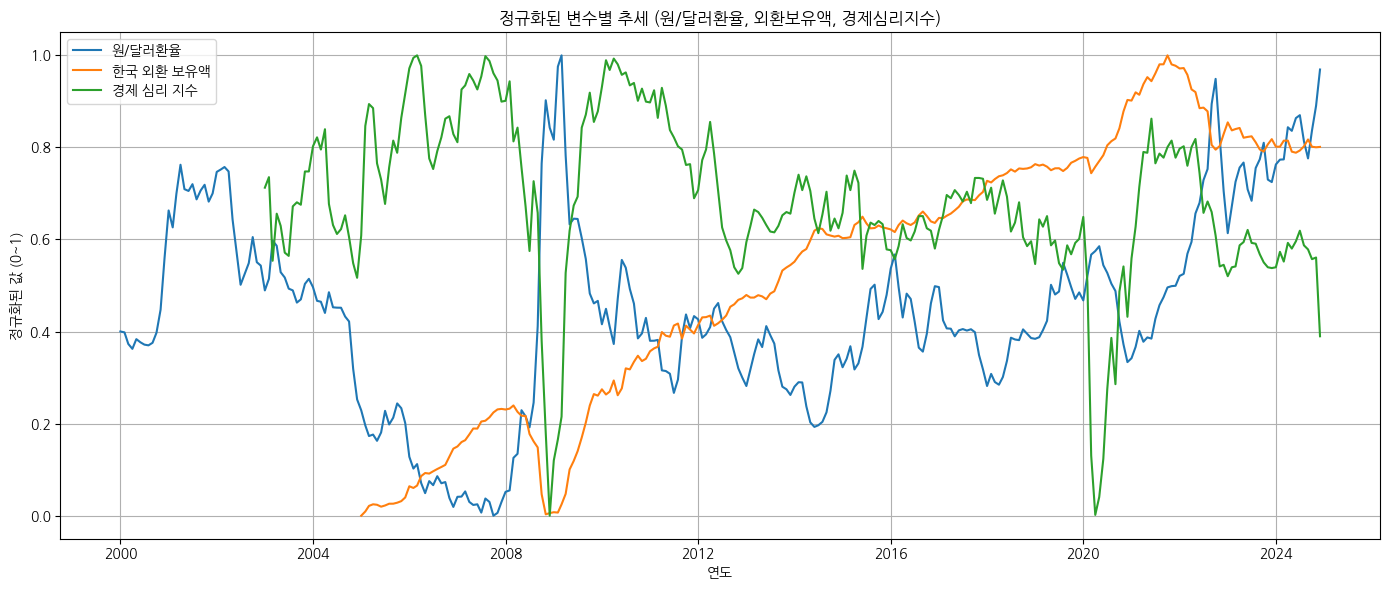

In [16]:
# 날짜 열을 datetime 형식으로 변환
df_exchange["TIME"] = pd.to_datetime(df_exchange["TIME"])

# 정규화 전용 복사본 생성
df_plot = df_exchange[["TIME", "원/달러환율", "한국 외환 보유액", "경제 심리 지수"]].copy()

# 정규화 (0~1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_plot.iloc[:, 1:] = scaler.fit_transform(df_plot.iloc[:, 1:])

# TIME을 인덱스로 설정
df_plot.set_index("TIME", inplace=True)

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(df_plot.index, df_plot["원/달러환율"], label="원/달러환율")
plt.plot(df_plot.index, df_plot["한국 외환 보유액"], label="한국 외환 보유액")
plt.plot(df_plot.index, df_plot["경제 심리 지수"], label="경제 심리 지수")
plt.legend()
plt.title("정규화된 변수별 추세 (원/달러환율, 외환보유액, 경제심리지수)")
plt.xlabel("연도")
plt.ylabel("정규화된 값 (0~1)")
plt.grid(True)
plt.tight_layout()
plt.show()


- 2000~2007: 환율 안정 + 외환보유액 증가 + 심리지수 상승

- 2008~2009: 글로벌 금융위기 (서브프라임 모기지)

  - 환율 급등 (원화 가치 폭락) → 1,100원대 → 1,500원대까지 급등

  - 외환보유액 일시적 급감 → 원화 방어 위해 외환시장에 달러 공급

  - 경제심리지수 급락 → 금융 불안, 실물경제 침체 우려 급증

- 2010~2014: 회복기

  - 환율 하락 (원화 강세 회복) → 외환보유액 다시 상승세

  - 경제 심리지수도 개선 → 세계 경기 회복 + 삼성전자 등 수출 호조

  - 2013~14: 미국 테이퍼링 언급 → 신흥국 불안 → 약간의 변동은 있지만 한국은 외환 안정 유지

- 2015~2019: 안정기 & 미중무역전쟁

  - 환율은 비교적 안정적 흐름

  - 외환보유액은 계속 증가 → 한국은행의 지속적 보유 전략

  - 경제심리지수는 점차 하락세
  
    → 내수 둔화, 청년 실업, 저성장 우려
    
    → 2018년 미중 무역전쟁 여파로 대외 불확실성 확대


- 2020~2021: 코로나19 충격

  - 환율 급등 (2020 초반) → 글로벌 달러 수요 폭증

  - 경제 심리지수 급락 후 반등 → 팬데믹 공포 → 정부 부양책 발표 → 회복 기대감

  - 외환보유액은 방어적으로 유지

- 2022~2023: 고금리·고환율 시대

  - 환율 급등 → 미국 기준금리 급격한 인상으로 달러 강세

  - 외환보유액 감소 → 원화 방어 위해 달러 매도한 흔적

  - 경제 심리지수 하락 → 고물가 + 경기침체 우려 → 소비·투자 둔화

- 2024: 최근

  - 환율은 다시 상승세 → 긴축 종료 이후에도 고환율 지속

  - 외환보유액은 보합 혹은 소폭 감소

  - 경제 심리지수도 둔화 중 → 금리 인하 기대와 경기 불확실성 혼재









► 경제심리지수는 환율보다 **선행적으로 움직이는 경향**
→ **소비자·기업의 기대가 먼저 변화**

#### 상관관계

In [17]:
# 상관관계 분석 (원/달러환율 기준)
target_corr = df_exchange.corr()["원/달러환율"].sort_values(ascending=False)
print(target_corr)

원/달러환율         1.000000
한국 외환 보유액      0.456148
미국 수출 총액       0.367506
미국 외환 보유액      0.344634
외국인 투자 금액      0.344115
TIME           0.278917
미국 수입 총액       0.252210
중국 수입 총액       0.210949
소득 교역 조건 지수    0.152396
전체 수입 총액       0.123010
한국 경상수지        0.107099
전체 수출 총액       0.092499
미국 기준 금리      -0.006208
한국 상품수지       -0.014387
중국 수출 총액      -0.030060
미국 상품수지       -0.030372
미국 경제성장률      -0.097279
한국 기준 금리      -0.106657
미국 경상수지       -0.123778
한국 경제성장률      -0.208054
경제 심리 지수      -0.562221
소비자동향지수             NaN
뉴스심리지수              NaN
Name: 원/달러환율, dtype: float64


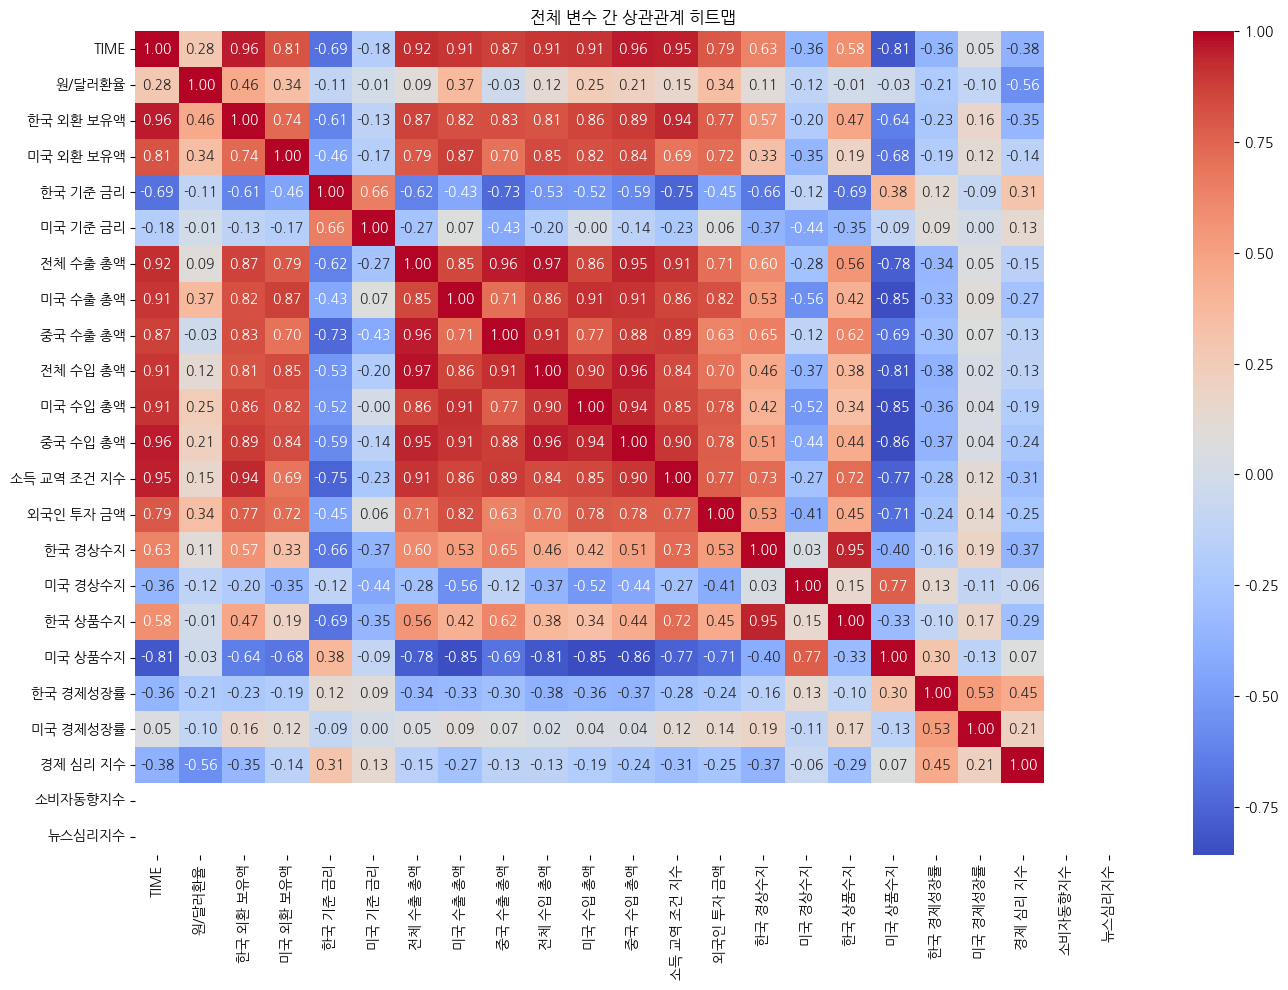

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(df_exchange.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("전체 변수 간 상관관계 히트맵")
plt.tight_layout()
plt.show()

- 한국 외환 보유액	/ 상관계수 : 0.456

  외환보유액이 많아질수록 환율이 오히려 상승? → 역설적으로 위기 시 외환보유액 축적 가능성

- 경제 심리 지수	/ 상관계수 : -0.562
  
  경제 심리가 나빠질수록 (지수가 낮을수록) 환율 상승 → 매우 강한 역상관!

- 미국 수출 총액, 미국 외환 보유액, 외국인 투자 금액 / 상관계수 : 0.3~0.4

  증가할 수록 환율 상승 경향

  외국인 투자 상승시 환율 상승? → 기대와 다름 확인할 것

- 무역 구조적 변수들(수출입, 경상수지 등) 은 중간정도의 영향만 / 기준금리는 영향 미미

## 경제심리지수와 환율 변화

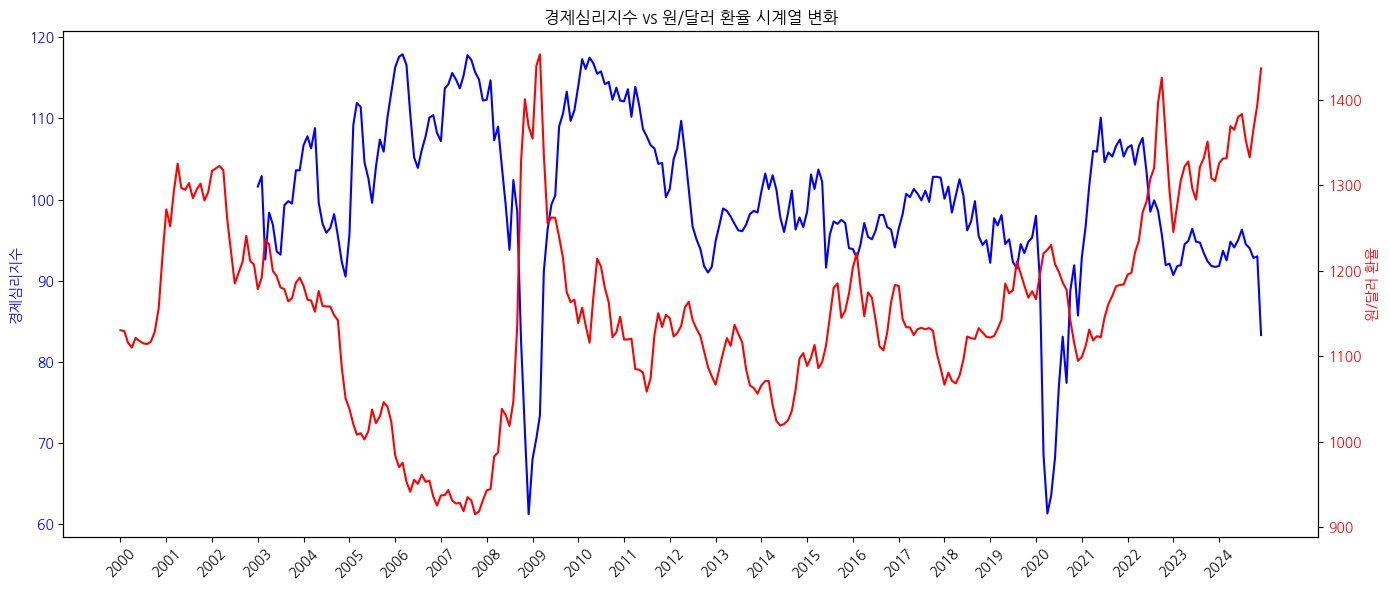

In [19]:
import matplotlib.pyplot as plt

# 'TIME'을 datetime으로 변환 (필요 시)
df_plot = df_merged.copy()
df_plot = df_plot.reset_index()  # TIME이 index에 있을 수도 있으므로 컬럼으로 옮김
df_plot["TIME"] = pd.to_datetime(df_plot["TIME"].astype(str))  # Period → datetime 변환
df_plot["연도"] = df_plot["TIME"].dt.year

# 연도별 첫 번째 날짜만 사용해 x축 눈금 위치 설정
year_ticks = df_plot.groupby("연도")["TIME"].first().values
year_labels = df_plot["연도"].unique()

# 시각화
plt.figure(figsize=(14, 6))

# 축 1: 경제심리지수
ax1 = plt.gca()
ax1.plot(df_plot["TIME"], df_plot["경제 심리 지수"], color="blue", label="경제심리지수")
ax1.set_ylabel("경제심리지수", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# 축 2: 환율
ax2 = ax1.twinx()
ax2.plot(df_plot["TIME"], df_plot["원/달러환율"], color="red", label="원/달러 환율")
ax2.set_ylabel("원/달러 환율", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# x축 연도만 출력
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(year_labels, rotation=45)

plt.title("경제심리지수 vs 원/달러 환율 시계열 변화")
plt.tight_layout()
plt.show()

| 연도       | 주요 이벤트                     | 경제심리지수 반응      | 원/달러 환율 반응         |
|------------|----------------------------------|-------------------------|----------------------------|
| **2001**   | 9·11 테러                        | 급격한 심리 하락       | 환율 상승 (원화 약세)      |
| **2008~09**| 글로벌 금융위기                  | 급락                    | 급등 (1500원대 접근)       |
| **2010~12**| 유럽 재정위기                    | 불안정                  | 등락 (1100~1200원 사이)    |
| **2015~16**| 위안화 절하, 브렉시트(영국 유럽연합 탈퇴)           | 심리 약화               | 상승 (불안 심화)           |
| **2020**   | 코로나 팬데믹                    | 급락                    | 급등 (위기 시 원화 약세)   |
| **2022~23**| 美 기준금리 급등 (연준 긴축)     | 심리 위축 지속          | 1400원 돌파 (환율 급등)     |
| **2024**   | 긴축 완화 기대, 환율 안정 기조   | 반등 시도               | 완만한 하락세              |


- 정말 미 기준금리가 급등했는가?

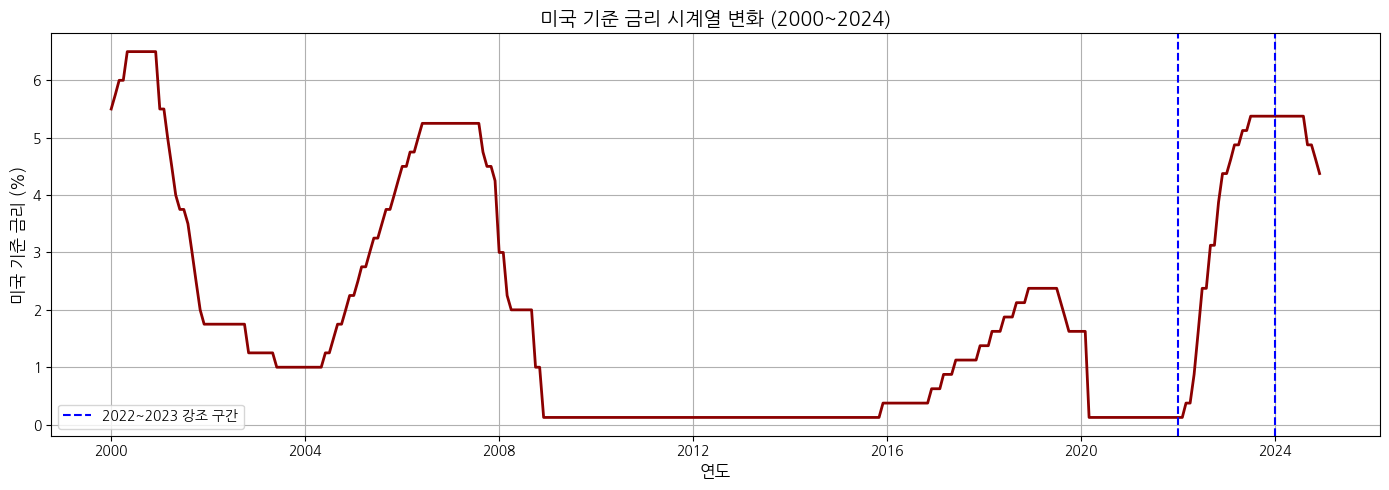

In [10]:
import matplotlib.pyplot as plt

# 시계열 시각화용 복사본
df_plot = df_merged.copy()
df_plot["TIME"] = pd.to_datetime(df_plot["TIME"])

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(df_plot["TIME"], df_plot["미국 기준 금리"], color='darkred', linewidth=2)

# 강조: 2022년과 2023년 구간 세로선 추가
plt.axvline(pd.Timestamp("2022-01-01"), color='blue', linestyle='--', linewidth=1.5, label='2022~2023 강조 구간')
plt.axvline(pd.Timestamp("2023-12-31"), color='blue', linestyle='--', linewidth=1.5)

# 꾸미기
plt.title("미국 기준 금리 시계열 변화 (2000~2024)", fontsize=14)
plt.xlabel("연도", fontsize=12)
plt.ylabel("미국 기준 금리 (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 펜데믹 전후로는 어떨까?

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# 팬데믹 기준 나누기
pre_covid = df_merged[df_merged["TIME"] < "2020-01"]
post_covid = df_merged[df_merged["TIME"] >= "2020-01"]

<ipython-input-14-e5e888e1347f>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-14-e5e888e1347f>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-14-e5e888e1347f>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


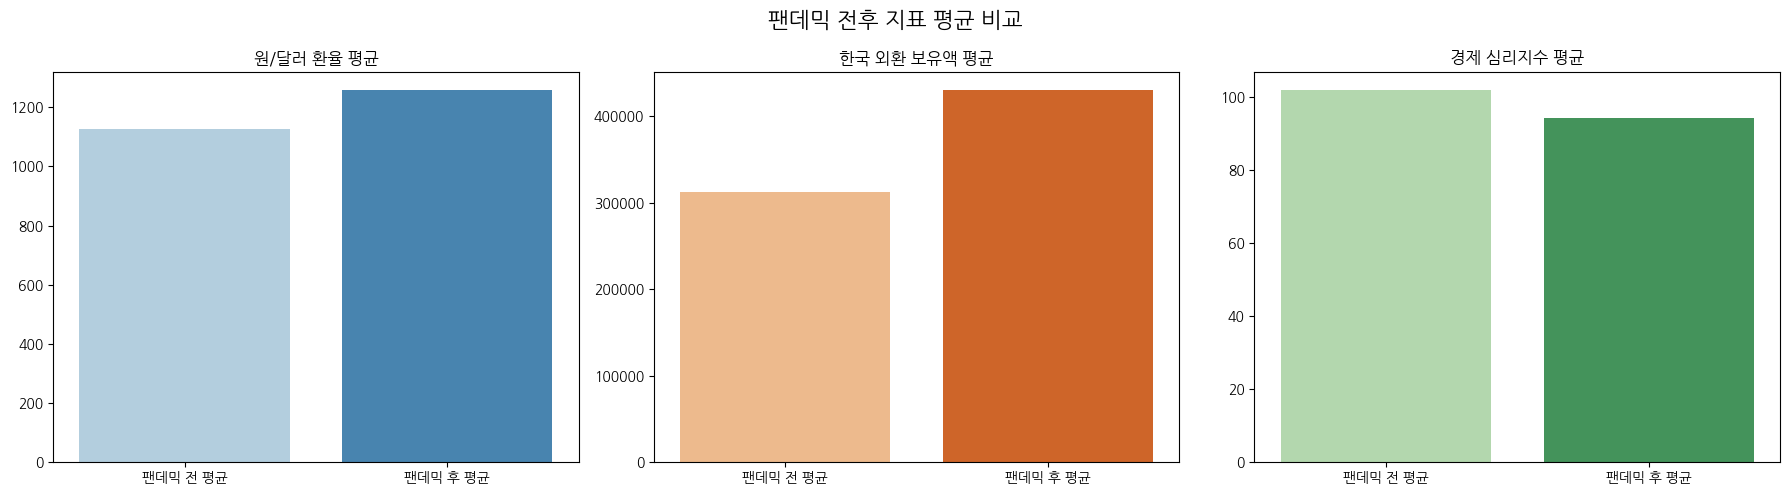

In [14]:
# 평균값 계산
compare_df = pd.DataFrame({
    "지표": ["원/달러환율", "한국 외환 보유액", "경제 심리 지수"],
    "팬데믹 전 평균": [
        pre_covid["원/달러환율"].mean(),
        pre_covid["한국 외환 보유액"].mean(),
        pre_covid["경제 심리 지수"].mean()
    ],
    "팬데믹 후 평균": [
        post_covid["원/달러환율"].mean(),
        post_covid["한국 외환 보유액"].mean(),
        post_covid["경제 심리 지수"].mean()
    ]
})

# 서브플롯으로 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ["원/달러 환율 평균", "한국 외환 보유액 평균", "경제 심리지수 평균"]
colors = ["Blues", "Oranges", "Greens"]

for i, indicator in enumerate(compare_df["지표"]):
    sns.barplot(
        data=pd.melt(compare_df[compare_df["지표"] == indicator],
                     id_vars="지표", var_name="시기", value_name="값"),
        x="시기", y="값", ax=axes[i], palette=colors[i]
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

plt.suptitle("팬데믹 전후 지표 평균 비교", fontsize=16)
plt.tight_layout()
plt.show()

- 원달러 환율 평균 상승 : 미 금리 인상과 더불어 글로벌경기 불확실성 영향

- 한국 외환보유액 상승 : 무조건 펜데믹 때문이라고 보긴 어렵지만,
위기대응력 강화위하여 외환 보유액 확대

- 경제심리지수 하락 : 펜데믹 이후 경제 불확실성/ 심리적 위축 가능성

### 지금까지 경제심리지수 분석

1. 환율과 뚜렷한 **음의 상관관계 확인** (-0.56)

2. **팬데믹 이후 평균 감소**: 경제 불확실성 상승, 신뢰 하락

3. 심리지수 급락 시기 ↔ 환율 급등 시기 대체로 **일치**

4. **미국 기준금리 급등기**(2022~2023)에도 **하락**

### 정책적 이벤트와 경제심리지수 확인

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# TIME 컬럼을 datetime으로 변환 (필요 시)
df_plot = df_merged.copy()
df_plot["TIME"] = pd.to_datetime(df_plot["TIME"].astype(str))  # Period → datetime 변환

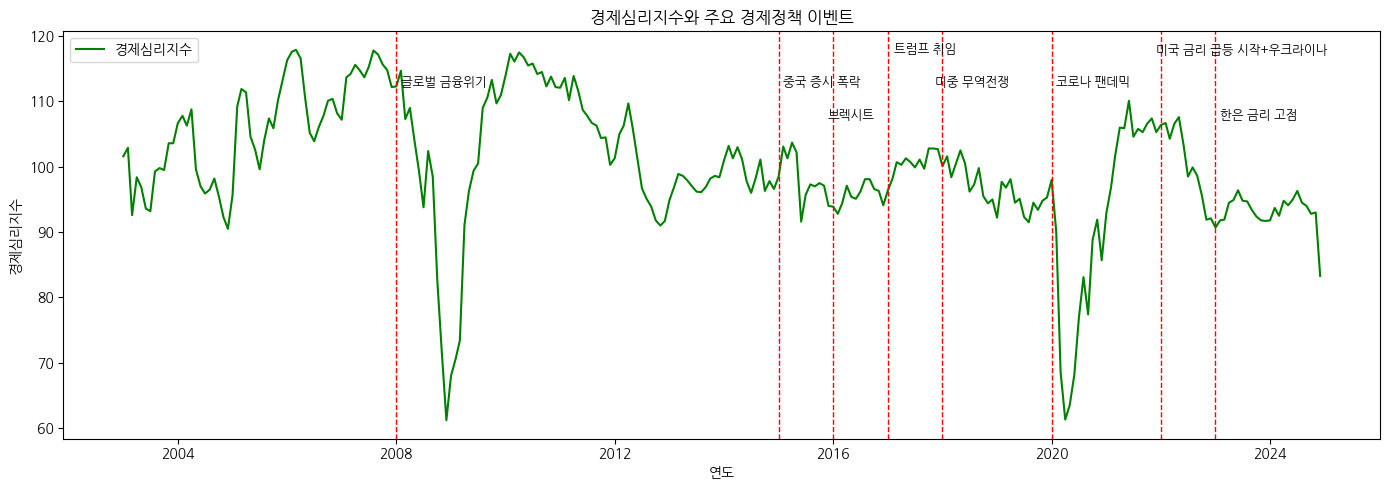

In [12]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=df_plot, x="TIME", y="경제 심리 지수", color="green", label="경제심리지수")
plt.title("경제심리지수와 주요 경제정책 이벤트")
plt.xlabel("연도")
plt.ylabel("경제심리지수")

# 주요 이벤트 추가
event_years = {
    "2008": "글로벌 금융위기",
    "2015": "중국 증시 폭락",
    "2016": "브렉시트",
    "2017": "트럼프 취임",
    "2018": "미중 무역전쟁",
    "2020": "코로나 팬데믹",
    "2022": "미국 금리 급등 시작+우크라이나",
    "2023": "한은 금리 고점"
}

# y축 기준점 설정
y_base = df_plot["경제 심리 지수"].max() - 5

# 라벨 위치 조정 사전 설정
label_offsets = {
    "2008": (30, 0),
    "2015": (30, 0),
    "2016": (-40, -5),
    "2017": (40, 5),
    "2018": (-50, 0),
    "2020": (30, 0),
    "2022": (-30, 5),
    "2023": (30, -5)
}

# 이벤트 선 및 라벨 표시
for year, label in event_years.items():
    event_date = pd.to_datetime(f"{year}-01-01")
    x_offset, y_offset = label_offsets[year]

    plt.axvline(event_date, color='red', linestyle='--', linewidth=1)
    plt.text(event_date + pd.DateOffset(days=x_offset),
             y_base + y_offset,
             label,
             rotation=0,
             verticalalignment='center',
             fontsize=9,
             color='black')

plt.tight_layout()
plt.show()


|시점 | 이벤트 | 경제심리지수 반응 | 해석|
|-------|----------|----------|-----|
2008년 | 글로벌 금융위기 | 급락 (역대 최저 수준) | 서브프라임 모기지 사태 → 리먼 브라더스 파산 → 글로벌 금융 시스템 불안감 폭발. 국민들의 경제적 불안이 크게 반영된 시점.
2015년 | 중국 증시 폭락 | 다소 하락 후 회복 | 한국 경제의 대중 의존도가 크기 때문에 불안감 반영. 다만 대폭락은 아님.
2016년 | 브렉시트 (영국 EU 탈퇴) | 크게 반응 없음 | 국내에 직접적인 영향보다는 세계 경제 불확실성 측면. 경제 주체들이 크게 동요하진 않았음.
2017년 | 트럼프 취임 | 약간 하락 | 보호무역주의 및 외교 불확실성 우려. 반면 주가 상승 기대도 일부 존재.
2018년 | 미중 무역전쟁 본격화 | 서서히 하락 | 교역 위축 우려 → 장기적인 불확실성 영향. 기업 및 소비자 모두 점진적 불안감 반영.
2020년 | 코로나 팬데믹 | 급락 (2008년과 유사 수준) | 팬데믹 충격, 이동 제한, 실물경제 침체에 대한 우려로 단기간 내 급격한 심리 위축.
2022년 | 미국 금리 급등 + 우크라이나 전쟁 | 하락세 지속 | 두 사건 모두 불확실성과 경기 침체 우려 증폭 → 소비 및 투자 심리 위축.
2023년 | 한국 기준금리 고점 도달 | 일시적 반등 후 정체 | "더 이상 오르지 않을 것"이라는 금리 피크 아웃 기대감 반영. 경기 회복 기대가 나타났지만 큰 전환은 없었음.

**요약**

  - 2008 금융위기, 2020 코로나는 급락 → 실물경제에 대한 직접적인 타격.
  - 그 외는 점진적 하락 혹은 미미한 반응.

  - 2022년 미국 금리 급등 때는 심리지수 하락 지속.

  - 2023년 한국 금리 고점 도달은 일시적인 심리 회복 기대감을 유도 → 금리 인하 기대 때문.

      
      금리 고점?
        → 금리 인상 고점에 도달했다는 건 더 이상 금리를 올리지 않을 가능성이 커졌다는 뜻 (“최악은 지나갔다”는 심리 반영)
        
        아직 실제 금리 인하가 시작되지 않았어도, 기대 심리만으로 경제심리지수가 반등할 수 있음.(일시적)

        만약 실제로 발생하지 않는다면 금세 경제 심리지수 하락

  - 정책 전환의 "신호" 자체가 경제심리에 강하게 작용

### 기대인플레이션율도 경제심리지수와 원/달러 환율에 영향을 미칠까?

기대인플레이션율 : 앞으로 1년간 얼마나 물가가 오를지

- ⬆︎ : 금리 인상 가능성이 커지고, 환율도 불안정 가능성

- ⬇︎ : 경기 둔화, 물가 안정 신호로 해석 가능

In [29]:
import pandas as pd
import requests

stat_code = '511Y003'     # 기대인플레이션율 (전국, 월)
item_code = 'FMB'         # 향후 1년 기대인플레이션율
start_date = '200808'     # 데이터 시작: 2008년 8월
end_date = '202503'       # 최신 데이터까지

# API URL 구성
url = f'https://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/{stat_code}/M/{start_date}/{end_date}/{item_code}'

# 요청
response = requests.get(url)
data = response.json()

# 데이터프레임 구성
if 'StatisticSearch' in data:
    rows = data['StatisticSearch']['row']
    df_expectation = pd.DataFrame(rows)
    df_expectation = df_expectation[['TIME', 'DATA_VALUE']]
    df_expectation.columns = ['TIME', '기대인플레이션율']
    df_expectation['TIME'] = pd.to_datetime(df_expectation['TIME'], format='%Y%m')
    df_expectation['기대인플레이션율'] = df_expectation['기대인플레이션율'].astype(float)
    print(df_expectation.head())
else:
    print("API 오류:", data)

        TIME  기대인플레이션율
0 2008-08-01       4.2
1 2008-09-01       4.5
2 2008-10-01       4.6
3 2008-11-01       4.5
4 2008-12-01       4.3


In [30]:
# TIME 형식을 datetime으로 변환 (df_merged)
df_merged['TIME'] = pd.to_datetime(df_merged['TIME'])

# 이제 병합
df_combined = pd.merge(df_merged, df_expectation, on='TIME', how='left')

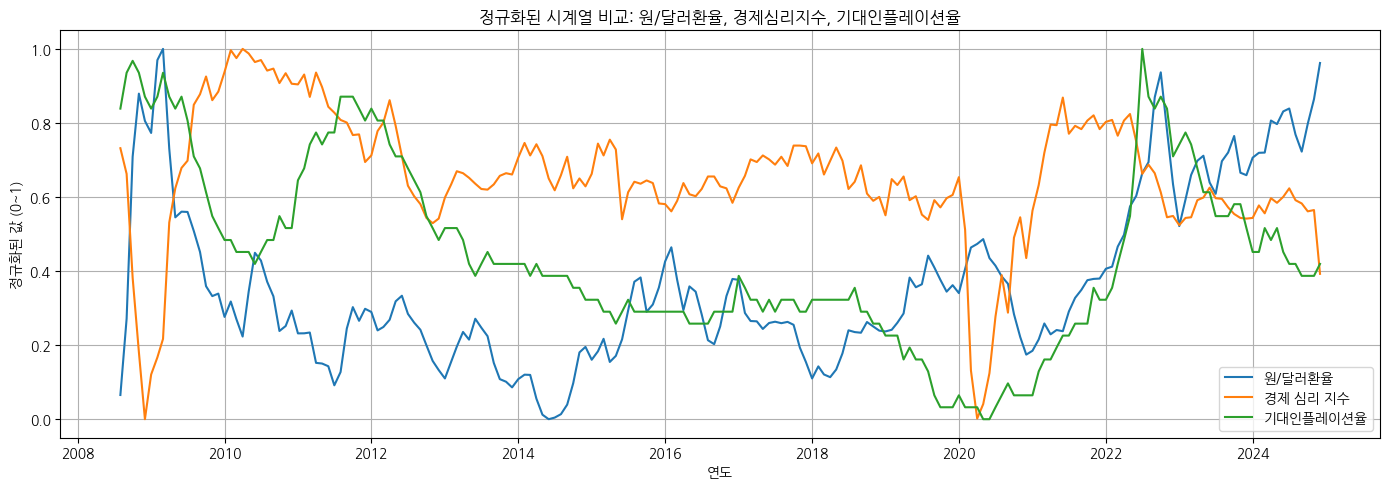

In [21]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 그래프용 복사본 생성
plot_df = df_combined[['TIME', '원/달러환율', '경제 심리 지수', '기대인플레이션율']].dropna()

# 정규화 (0~1 범위로 스케일링)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(plot_df[['원/달러환율', '경제 심리 지수', '기대인플레이션율']])
scaled_df = pd.DataFrame(scaled, columns=['원/달러환율', '경제 심리 지수', '기대인플레이션율'])
scaled_df['TIME'] = plot_df['TIME'].values

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(scaled_df['TIME'], scaled_df['원/달러환율'], label='원/달러환율')
plt.plot(scaled_df['TIME'], scaled_df['경제 심리 지수'], label='경제 심리 지수')
plt.plot(scaled_df['TIME'], scaled_df['기대인플레이션율'], label='기대인플레이션율')
plt.title("정규화된 시계열 비교: 원/달러환율, 경제심리지수, 기대인플레이션율")
plt.xlabel("연도")
plt.ylabel("정규화된 값 (0~1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**해석**

1. 2008~2009: 글로벌 금융위기 직후

  - 경제심리지수 급락 → 소비자 심리가 급격히 위축된 시기

  - 환율 급등 → 외환시장 불안, 원화가치 하락

  - 기대인플레이션율도 상승 → 향후 물가 상승 예상, 불확실성 반영

2. 2012~2015: 안정기

  - 경제심리지수는 점진적 회복 → 경기 회복 기대감

  - 환율과 기대인플레이션율은 모두 하락세 → 대체로 안정적 물가 및 환율 수준

3. 2016~2018: 미중 무역전쟁 & 정치적 리스크

  - 기대인플레이션율은 서서히 하락 → 물가 안정 기대

  - 경제심리지수도 하락세로 전환 → 무역 불확실성, 글로벌 리스크 반영

  - 환율은 상대적으로 안정적

  : 기대인플레이션율과 심리지수는 비슷한 경향 : 경기 둔화 예상

4. 2020: 코로나 팬데믹

  - 경제심리지수 폭락 → 사상 최저 수준

  - 환율 급등 → 안전자산 선호, 원화 약세

  - 기대인플레이션율도 최저 수준 도달 → 소비심리 위축, 물가 우려 약화

  : 셋 다 동반 하락으로 경제 침체 명확

5. 2022~2023: 고물가 & 고금리 시대

  - 환율 급등 → 미국 금리 인상, 원화 약세

  - 기대인플레이션율 급상승 → 향후 물가 상승 강하게 인식됨

  - 경제심리지수는 오히려 반등했다가 다시 하락 → 일시적 기대감이 있었던 것으로 보임

  : 세 지표의 방향이 잠시 갈리며 해석이 복잡


6. 2023 후반~2024: 금리 고점 도달 및 기대 반영

  - 기대인플레이션율은 하락세 전환 → 물가 안정 기대

  - 경제심리지수는 하락 → 체감 경기 회복 부진

  - 환율은 조금 하락했다가 다시 상승 → 불안정한 글로벌 요인(우크라이나전쟁등) 지속





- subplot 으로 정규화 안된 그래프 비교

### 외국인 투자 금액(파란색)과 경제심리지수(초록색)

In [41]:
df_merged.columns

Index(['Unnamed: 0', 'TIME', '원/달러환율', '한국 외환 보유액', '미국 외환 보유액', '한국 기준 금리',
       '미국 기준 금리', '전체 수출 총액', '미국 수출 총액', '중국 수출 총액', '전체 수입 총액', '미국 수입 총액',
       '중국 수입 총액', '소득 교역 조건 지수', '외국인 투자 금액', '한국 경상수지', '미국 경상수지', '한국 상품수지',
       '미국 상품수지', '한국 경제성장률', '미국 경제성장률', '경제 심리 지수', '소비자동향지수', '뉴스심리지수',
       '기대인플레이션율'],
      dtype='object')

<ipython-input-45-3463513fa85d>:30: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
<ipython-input-45-3463513fa85d>:30: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
<ipython-input-45-3463513fa85d>:30: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
<ipython-input-45-3463513fa85d>:30: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
<ipython-input-45-3463513fa85d>:30: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
<ipython-input-45-3463513fa85d>:30: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
<ipython-input-45-3463513fa85d>:30: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
<ipyth

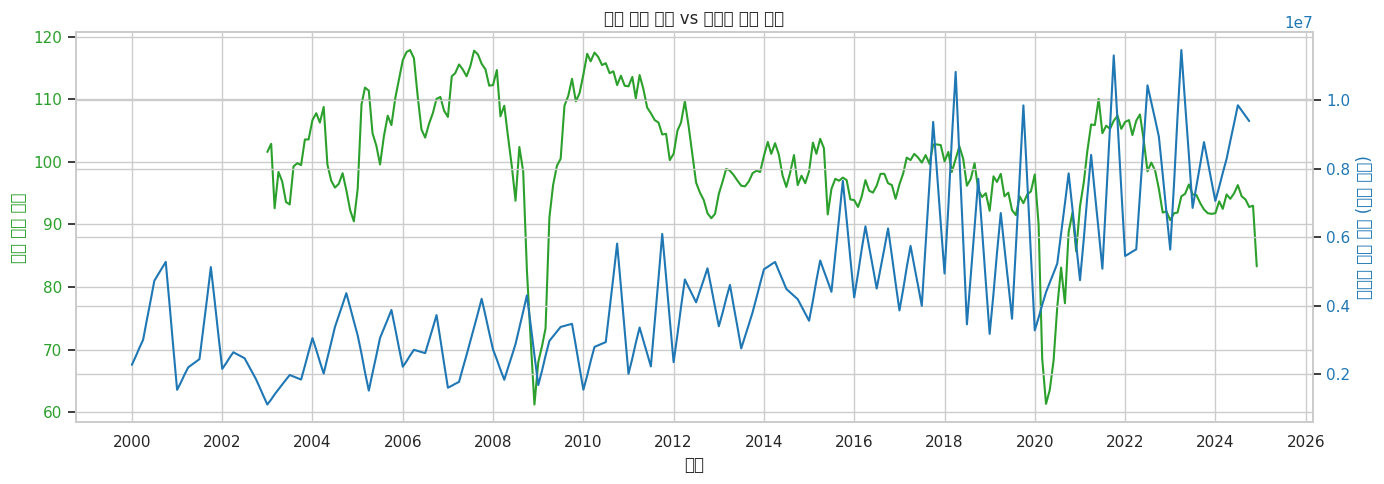

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 시간 형식 처리
df_merged["TIME"] = pd.to_datetime(df_merged["TIME"])

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(14, 5))

# 왼쪽 y축: 경제 심리 지수
color = "tab:green"
ax1.set_xlabel("연도")
ax1.set_ylabel("경제 심리 지수", color=color)
ax1.plot(df_merged["TIME"], df_merged["경제 심리 지수"], color=color, label="경제 심리 지수")
ax1.tick_params(axis='y', labelcolor=color)

# 오른쪽 y축: 외국인 투자 금액
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("외국인 투자 금액 (백만 달러)", color=color)
ax2.plot(df_merged["TIME"], df_merged["외국인 투자 금액"], color=color, label="외국인 투자 금액")
ax2.tick_params(axis='y', labelcolor=color)

# 연도 단위 x축 포맷 설정
ax1.xaxis.set_major_locator(mdates.YearLocator(2))  # 2년 간격
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 제목 및 레이아웃
plt.title("경제 심리 지수 vs 외국인 투자 금액")
fig.tight_layout()
plt.show()

| 구간        | 경제심리지수 | 외국인투자금액 | 특징                             |
|-------------|----------------|------------------|----------------------------------|
| 2000~2007   | 상승           | 유지/증가         | 안정 성장기                       |
| 2008        | 급락           | 급감              | 글로벌 금융위기 충격              |
| 2010~2015   | 회복세         | 증가              | 외자 유입 회복                   |
| 2018 이후   | 하락           | 변동 중 증가       | 미중 무역, 코로나, 고금리 혼재     |
| 2022~2024   | 지속 하락       | 증가              | 실물심리 악화 vs 자본 유입        |


* 2022-2023년의 경우

  경기 체감은 악화되었지만,

  고금리 환경과 환차익 기대 등으로 외국인 자금은 유입되는 모습.

  심리가 실제 자금 흐름과 꼭 일치하지는 않음을 보여줌.


* 특히 , 고금리/환율 이슈가 외자 유입을 자극하는 경우, 심리와 반대 흐름도 가능

  - 고금리 상황:

    한국이 기준금리를 높이면, 금리 차익을 노리는 외국인 투자자들이 자금을 한국에 투자하려고 함.
  → 외국인 투자금액 증가

  - 환율 상승(원화 약세):

    달러 대비 원화 가치가 떨어지면, 외국인 입장에서는 상대적으로 싸게 투자할 수 있는 기회.

- "외국인 투자 금액", "경제 심리 지수"의 상관관계

In [46]:
corr_1 = df_merged[["외국인 투자 금액", "경제 심리 지수"]].corr().iloc[0, 1]
print(f"외국인 투자 금액과 경제 심리지수 간 상관계수: {corr_1:.3f}")

외국인 투자 금액과 경제 심리지수 간 상관계수: -0.250


### 외국인 투자금액 vs 외환보유액

<ipython-input-48-15749d41206c>:27: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-15749d41206c>:27: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-15749d41206c>:27: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-15749d41206c>:27: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-15749d41206c>:27: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-15749d41206c>:27: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-15749d41206c>:27: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-i

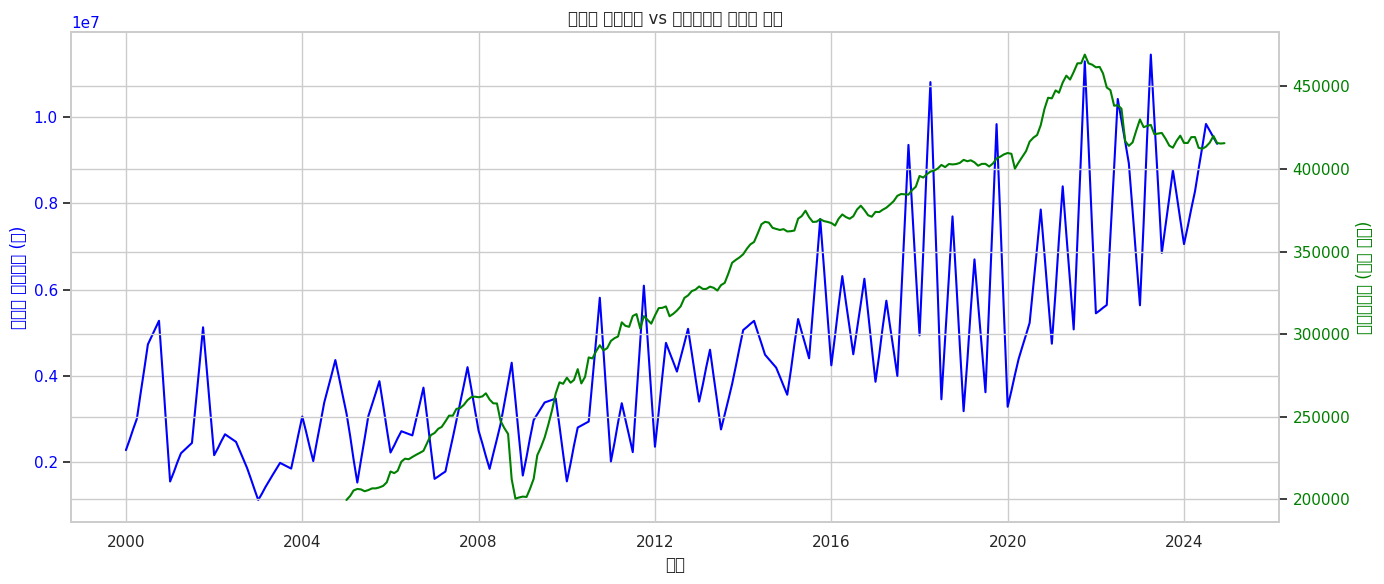

In [48]:
import matplotlib.pyplot as plt

# 데이터프레임 복사 및 시간 변환
df_plot = df_merged.copy()
df_plot = df_plot.reset_index()
df_plot["TIME"] = pd.to_datetime(df_plot["TIME"].astype(str))

# 시각화
plt.figure(figsize=(14, 6))

# 축 1: 외국인 투자금액
ax1 = plt.gca()
ax1.plot(df_plot["TIME"], df_plot["외국인 투자 금액"], color="blue", label="외국인 투자금액")
ax1.set_ylabel("외국인 투자금액 (원)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# 축 2: 외환보유액
ax2 = ax1.twinx()
ax2.plot(df_plot["TIME"], df_plot["한국 외환 보유액"], color="green", label="한국 외환보유액")
ax2.set_ylabel("외환보유액 (백만 달러)", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# x축 설정
ax1.set_xlabel("연도")
plt.title("외국인 투자금액 vs 외환보유액 시계열 변화")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
corr_2 = df_merged[["외국인 투자 금액", "한국 외환 보유액"]].corr().iloc[0, 1]
print(f"외국인 투자 금액과 외환보유액 간 상관계수: {corr_2:.3f}")

외국인 투자 금액과 외환보유액 간 상관계수: 0.769


그래프에서 외환보유액(초록색)은 전체적으로 꾸준한 상승세를 보이며,

외국인 투자금액(파란색)은 변동성이 크지만, 장기적으로는 우상향

➔ 즉 외국인 투자 유입이 직접적인 외환보유액 확대 요인으로 작용

#### **경제심리지수의 가설 설정**

- 경제심리지수가 낮을수록 원/달러 환율은 상승한다
- 경제심리지수는 외환보유액 확대와 반대 방향으로 움직일 수 있다 (심리악화되면 대응책으로 외화보유액 증가하는 것 보았음)
- 경제심리지수는 외국인투자유입에 영향을 준다


#### **외환보유금액의 가설 설정**

- 외국인 투자 유입이 외환보유액을 증가시킨다.
- 외환보유액 증가는 원/달러 환율 안정에 기여한다
- 외국인 투자금액은 환율 수준과 금리 차에 민감하게 반응한다
  ex) 한국 금리 고점 도달 → 외자 유입 증가



